In [3]:
# Basic data manipulation and visualisation libraries
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import glob

# Network Libraries
import networkx as nx
from nxviz import CircosPlot
import community

# Libraries used for Topological Data Analysis 
import gudhi

# Magic command to change plotting backend
#%matplotlib qt

# Magic command to load watermark
#%load_ext watermark

In [4]:
# Possibility to stop warnings
import warnings

warnings.filterwarnings('ignore') 

In [3]:
# Print versions
%watermark --author "Eduarda & Fernando" --date --time --python --machine --iversion --watermark 

UsageError: Line magic function `%watermark` not found.


In [5]:
# load data
import numpy as np
import glob
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx
import os

def load_matrices_simple(results_dir, n_rois=400):
    """
    Simple function to load and average connectivity matrices
    
    Parameters:
    results_dir (str): Directory containing connectivity matrices
    n_rois (int): Number of ROIs (200 or 400)
    
    Returns:
    tuple: (averaged_matrix, region_labels)
    """
    # Load all individual matrices
    matrix_files = glob.glob(f'{results_dir}/connectivity_matrices_{n_rois}/*_connectivity_matrix.npy')
    #matrix_files = glob.glob(f'{results_dir}/connectivity_matrices/*_connectivity_matrix.npy')
    
    if not matrix_files:
        raise FileNotFoundError(f"No connectivity matrices found in {results_dir}/connectivity_matrices_{n_rois}/")
    
    print(f"Found {len(matrix_files)} connectivity matrices")
    
    # Load and average matrices
    matrices = [np.load(file) for file in matrix_files]
    matrix = np.mean(matrices, axis=0)
    
    # Create simple region labels
    region_labels = [f"Region_{i+1}" for i in range(n_rois)]
    
    return matrix, region_labels


# Set up paths
results_dir = '/user_data/csimmon2/git_repos/ptoc/results'

# Create figures directory if it doesn't exist
#os.makedirs(f'{results_dir}/figures', exist_ok=True)

# Load 400 ROI data
matrix, region_labels = load_matrices_simple(results_dir, n_rois=400)

# Now you can proceed with the visualization functions

Found 19 connectivity matrices


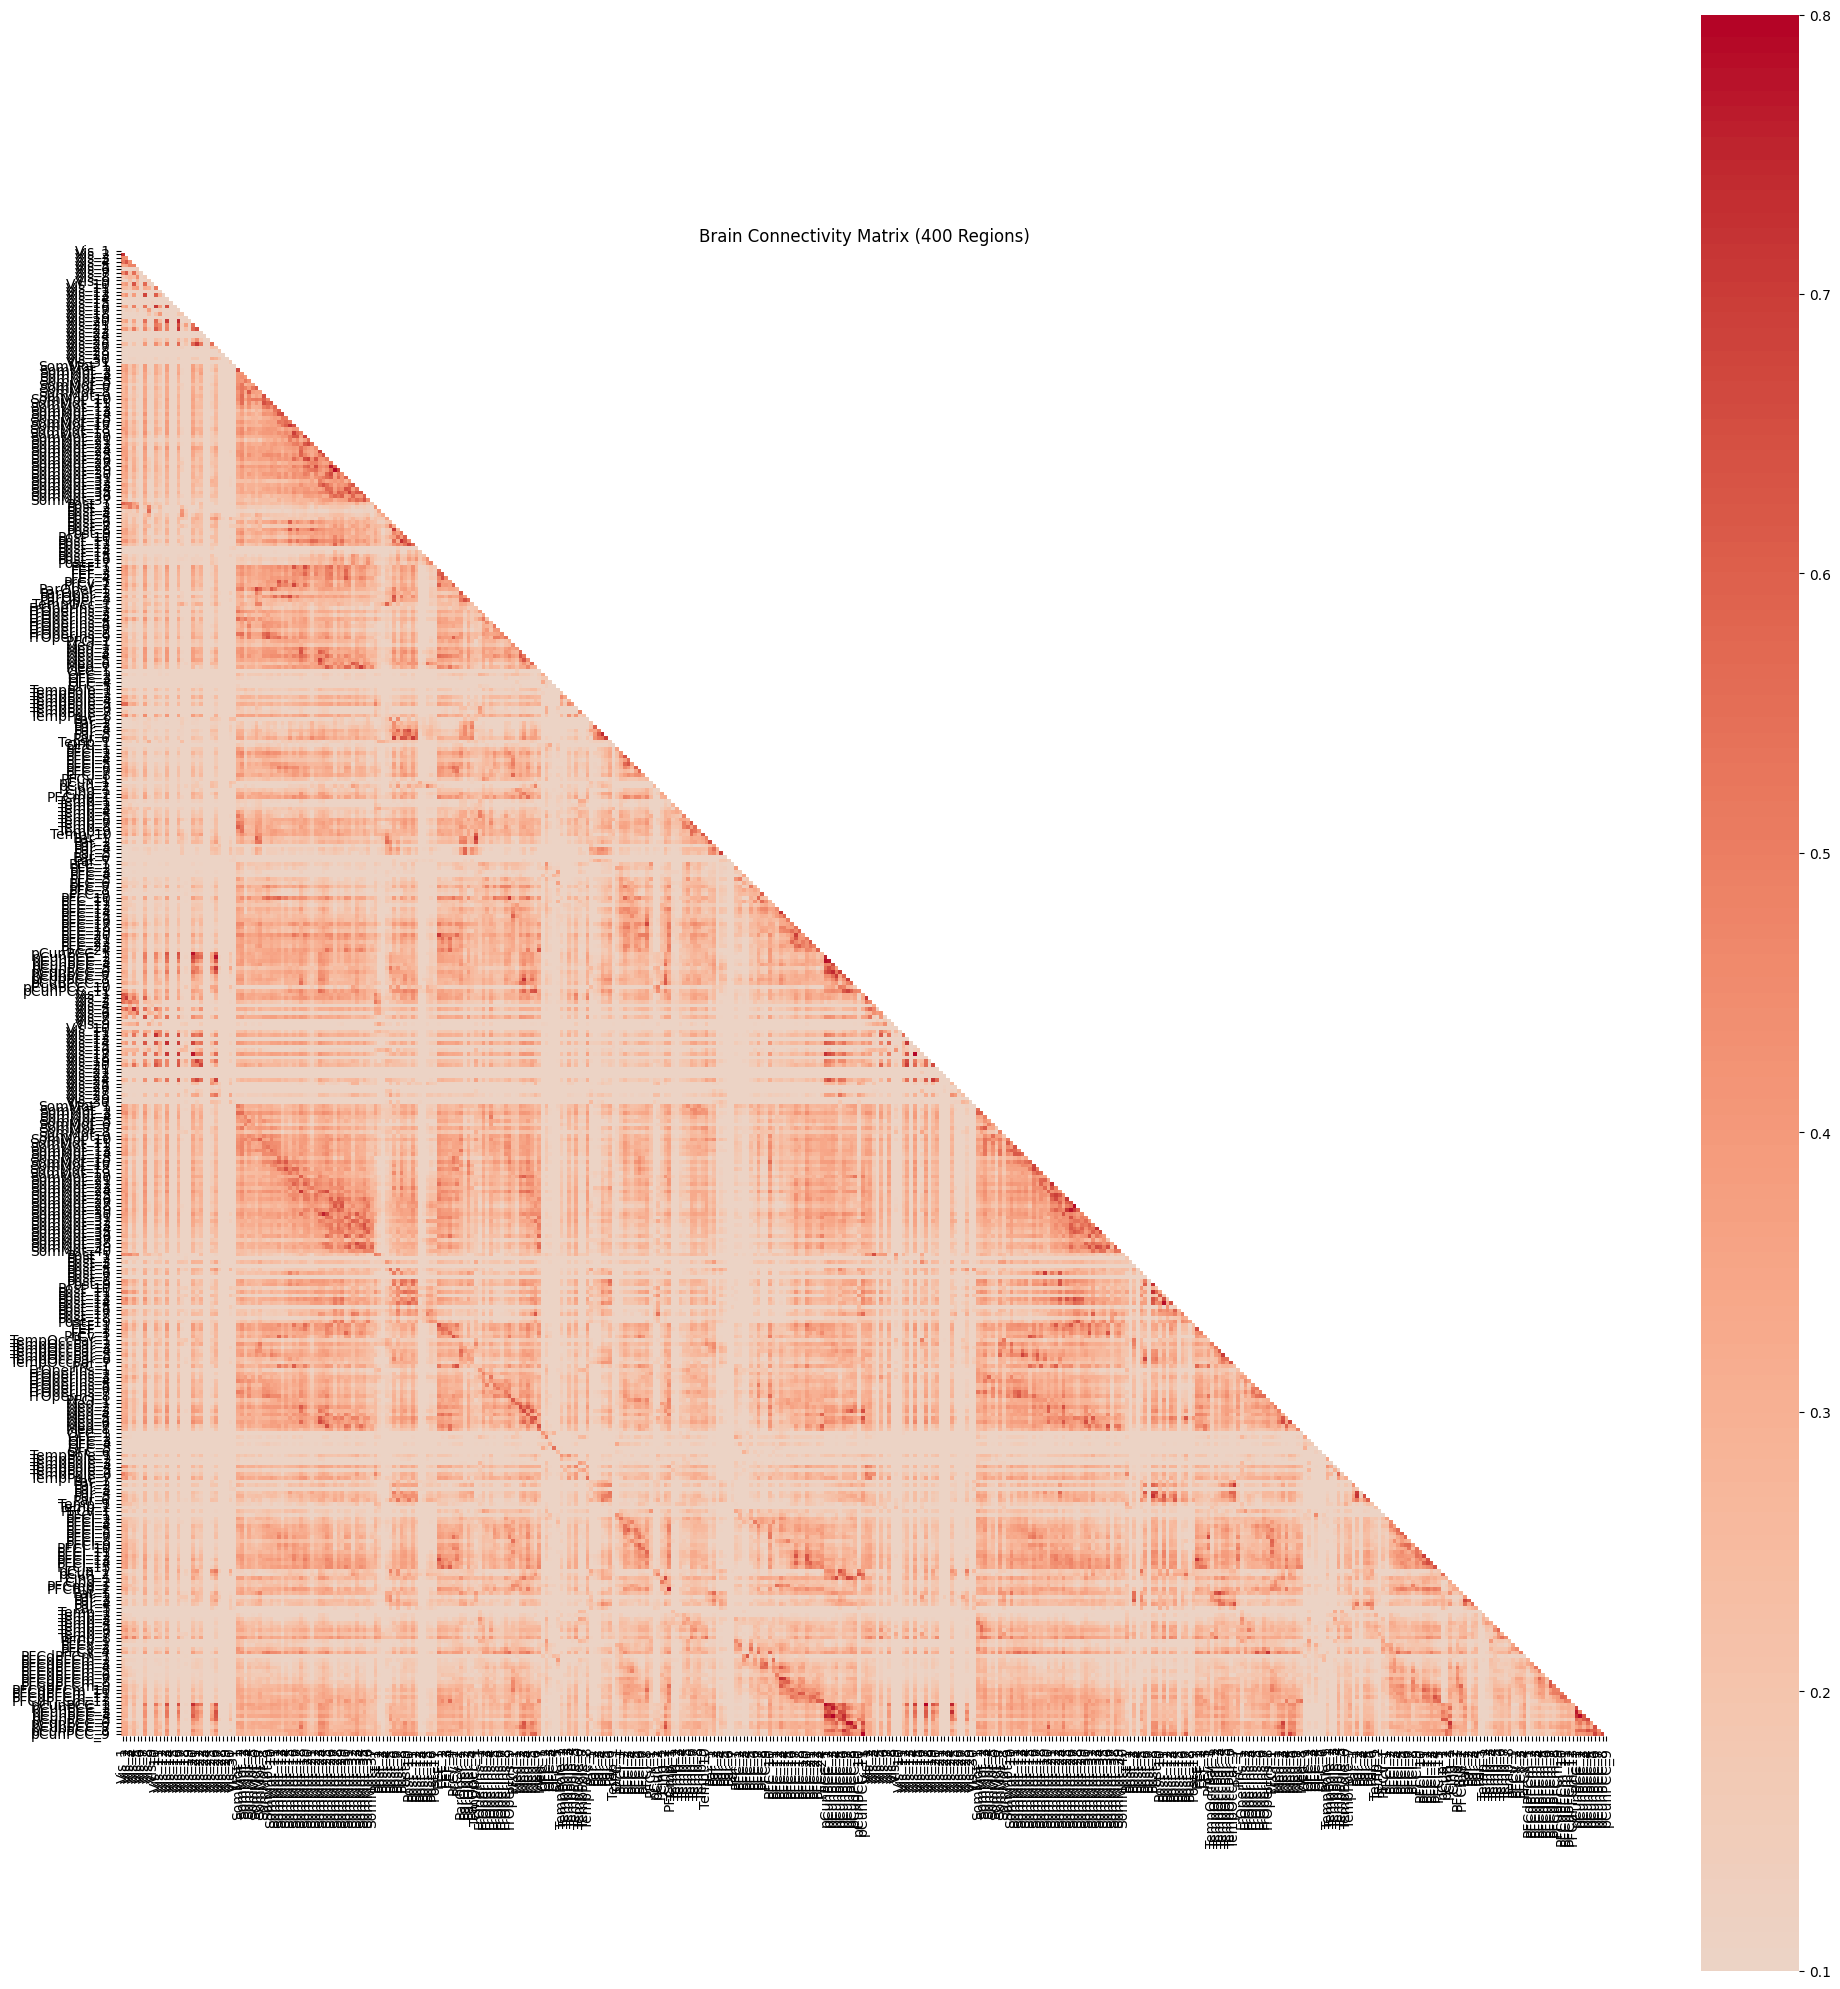

In [6]:
# heatmap
from nilearn import datasets
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Get Schaefer atlas and labels
schaefer_atlas = datasets.fetch_atlas_schaefer_2018(n_rois=400, resolution_mm=2)
labels = schaefer_atlas.labels

# Clean up labels - remove the prefix and hemisphere info for clarity
clean_labels = [label.decode('utf-8').split('_')[-2] + '_' + label.decode('utf-8').split('_')[-1] 
               for label in labels]

# Create figure with square aspect ratio
plt.figure(figsize=(20, 20))

# Create mask for upper triangle
mask = np.zeros_like(matrix, dtype=bool)
mask[np.triu_indices_from(mask)] = True

# Create the heatmap
sns.heatmap(matrix, 
            cmap='coolwarm',
            center=0,
            cbar=True,
            square=True,  # Force square shape
            mask=mask,
            vmin=0.1,
            vmax=0.8,
            xticklabels=clean_labels,
            yticklabels=clean_labels)

# Rotate x-axis labels for better readability
plt.xticks(rotation=90)
plt.yticks(rotation=0)

plt.title('Brain Connectivity Matrix (400 Regions)')

# Adjust layout to prevent label cutoff
plt.tight_layout()

plt.show()

Network after thresholding and removing self-loops:
Number of nodes: 400
Number of edges: 25

After removing isolated nodes:
Number of nodes remaining: 29
Number of edges: 25


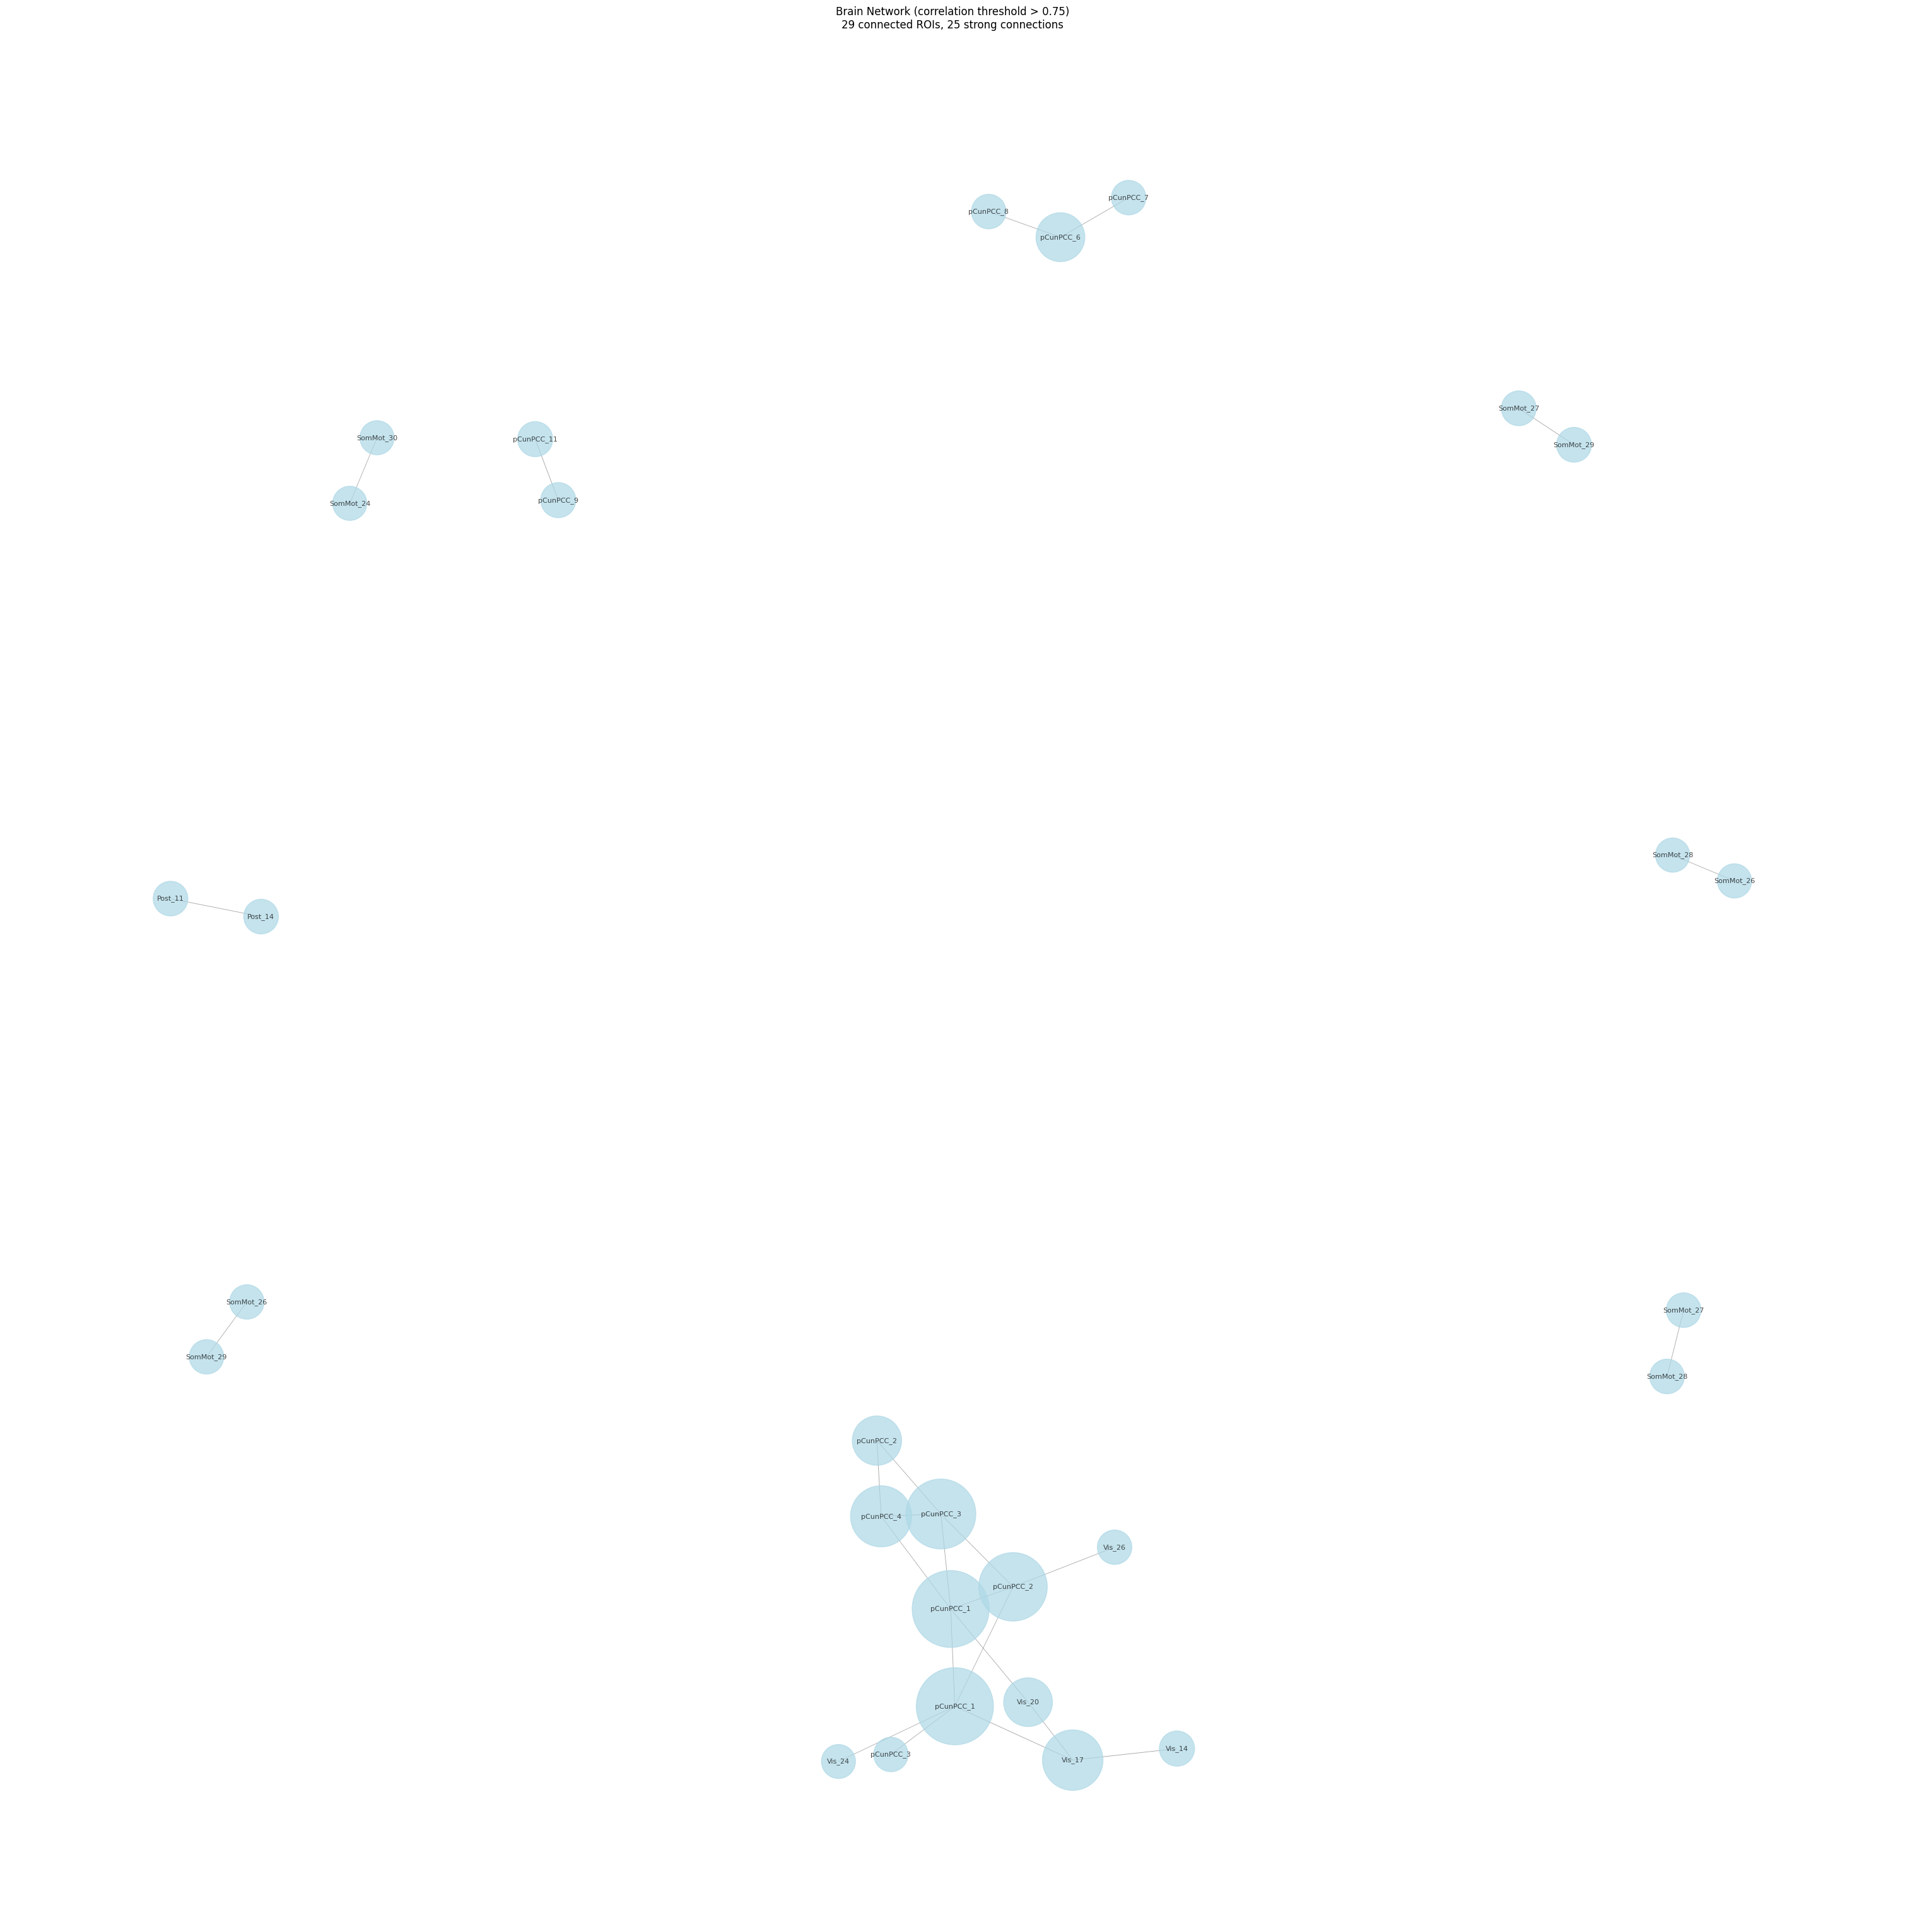

In [13]:
#graph theory analysis and visualization
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
from nilearn import datasets

# Get Schaefer atlas and labels
schaefer_atlas = datasets.fetch_atlas_schaefer_2018(n_rois=400, resolution_mm=2)
labels = schaefer_atlas.labels

# Clean up labels - remove the prefix and hemisphere info for clarity
clean_labels = [label.decode('utf-8').split('_')[-2] + '_' + label.decode('utf-8').split('_')[-1] 
                for label in labels]

# First create the thresholded matrix
matrix_thresholded = matrix.copy()
threshold = 0.75
matrix_thresholded[matrix_thresholded <= threshold] = 0

# Create graph from thresholded matrix
G = nx.from_numpy_array(matrix_thresholded)

# Remove self-loops
G.remove_edges_from(list(nx.selfloop_edges(G)))

print(f"Network after thresholding and removing self-loops:")
print(f"Number of nodes: {G.number_of_nodes()}")
print(f"Number of edges: {G.number_of_edges()}")

# Remove isolated nodes (nodes with no connections)
isolated_nodes = [node for node in G.nodes() if G.degree(node) == 0]
G.remove_nodes_from(isolated_nodes)

print(f"\nAfter removing isolated nodes:")
print(f"Number of nodes remaining: {G.number_of_nodes()}")
print(f"Number of edges: {G.number_of_edges()}")

# Create label dictionary for remaining nodes
node_labels = {node: clean_labels[node] for node in G.nodes()}

# Calculate normalized node strengths
strength = G.degree(weight='weight')
node_sizes = [val * 2000 for (node, val) in strength]  # Scale for visibility

# Set up the visualization
plt.figure(figsize=(30, 30))

# Calculate edge widths
edgewidth = [d['weight'] for (u,v,d) in G.edges(data=True)]
pos = nx.spring_layout(G, k=2/np.sqrt(G.number_of_nodes()), iterations=100)

# Draw network
nx.draw(G, pos, 
        with_labels=True, 
        width=np.power(edgewidth, 2),  # Square the edge widths
        edge_color='grey', 
        node_size=node_sizes,
        labels=node_labels,
        font_color='black', 
        node_color='lightblue',  # Can be modified based on your needs
        alpha=0.7, 
        font_size=8)

plt.title(f'Brain Network (correlation threshold > {threshold})\n'
          f'{G.number_of_nodes()} connected ROIs, {G.number_of_edges()} strong connections')

plt.show()

In [ ]:
#topology and geometry analysis and visualization
